In [6]:
import json
import pandas as pd
import numpy as np
import os
import shap
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [7]:
# Load data
folder_path = "results/"
data = []

for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith(".json"):
            file_path = os.path.join(root, filename)
            try:
                with open(file_path, "r") as f:
                    entry = json.load(f)
                    data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Skipped invalid JSON: {file_path} ({e})")

print(f"Loaded {len(data)} valid JSON result files from '{folder_path}' and its subfolders.")# Load embedding model

Loaded 295 valid JSON result files from 'results/' and its subfolders.


Plotting SHAP summary for class: llama_deepseek


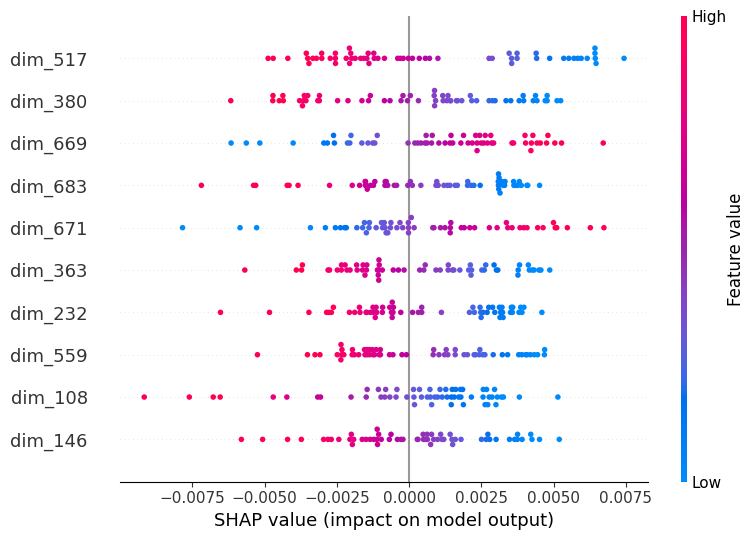

Plotting SHAP summary for class: llama_gpt


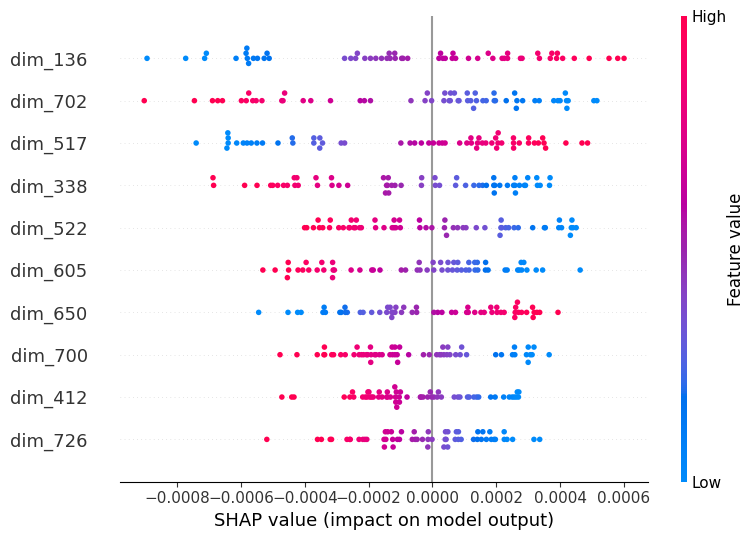

Plotting SHAP summary for class: llama_qwen


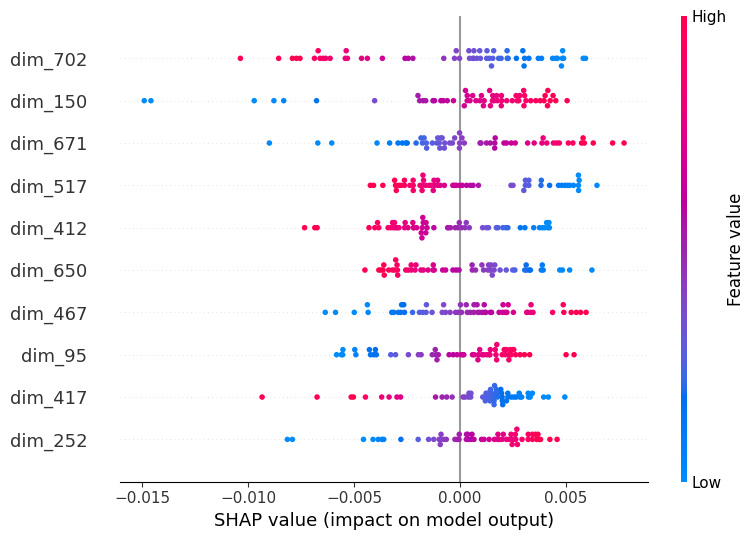

Plotting SHAP summary for class: qwen_deepseek


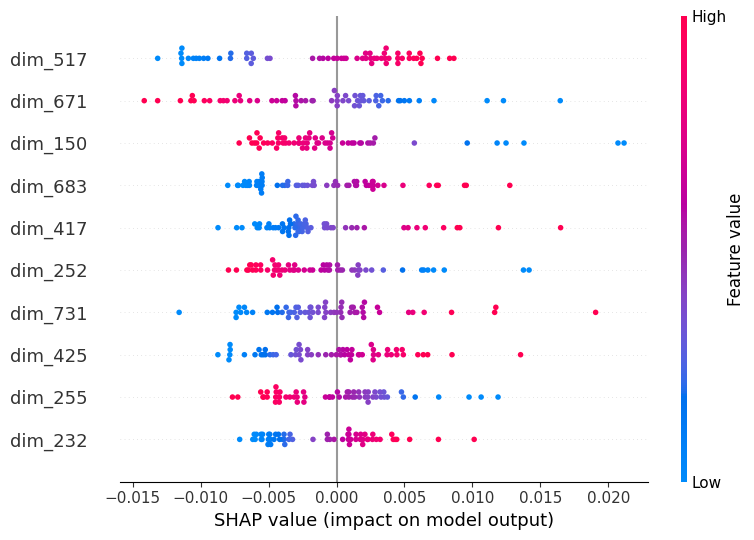

In [10]:
model = SentenceTransformer('sentence-t5-base')

# Prepare data
dialogues = []
labels = []
for run in data:
    dialogue = run["dialogue"]
    text = "\n".join([turn["content"] for turn in dialogue if "content" in turn])
    embedding = model.encode(text)
    label = f"{run['model_general_name_0']}_{run['model_general_name_1']}"
    dialogues.append(embedding)
    labels.append(label)

label_encoder = LabelEncoder()
X = np.vstack(dialogues)
y = label_encoder.fit_transform(labels)

# Split and train classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Run SHAP
explainer = shap.Explainer(clf, X_train, feature_names=[f"dim_{i}" for i in range(X.shape[1])])
shap_values = explainer(X_test)

class_names = label_encoder.classes_
for i, class_name in enumerate(class_names):
    print(f"Plotting SHAP summary for class: {class_name}")
    shap.summary_plot(shap_values[..., i], X_test, feature_names=[f"dim_{j}" for j in range(X.shape[1])], max_display=10)